# Simple CNN for PETALO

Esta red la vamos a utilizar para obtener el radio 

In [1]:
import numpy as np
#np.random.seed(1337)  # for reproducibility
from time import time
from datetime import datetime
# from sklearn import preprocessing
import sys

sys.path.append("/home/rgadea/lmfit-py/")
sys.path.append("/home/rgadea/experimentos/viherbos/")

print(sys.path)
import json 

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# import seaborn as sns
from keras.datasets import mnist
from keras.models import Model, Sequential, load_model
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D,Conv3D, MaxPooling3D, MaxPooling2D,BatchNormalization
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.utils import np_utils
from keras import regularizers
from keras.optimizers import Adam, Nadam, RMSprop, SGD
from math import floor
from lmfit.models import  GaussianModel
import matplotlib.pyplot as plt

['/home/rgadea/anaconda3/envs/tensorflow3/lib/python36.zip', '/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6', '/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6/lib-dynload', '', '/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6/site-packages', '/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/IPython/extensions', '/volumedisk0/home/rgadea/.ipython', '/home/rgadea/lmfit-py/', '/home/rgadea/experimentos/viherbos/']


Using TensorFlow backend.
/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home

In [2]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()
import tensorflow as tf
print(tf.__version__)
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

1.13.1


## Vamos introducir los datos de petalo preprocesados en pyhton


In [3]:
# import scipy.io as sio
# import Event_Handle_red as  eh
# # import hdf5storage
# # datos_matlab = hdf5storage.loadmat('../datos_junio_2019/conjunto_entrenamiento_junio_2019_pitch7mm_rad165mm_29_total_2_distancias_red.mat')
# # conjunto_datos= datos_matlab.get('photodefbox2_todo_fil5')

# # npzfile = np.load('../conjuntos_datos_reconstruidos/fil5_pith7mm_rad165mm_scaled2_sig_sig_1200.npz')
# # npzfile.files
# path = "/home/rgadea/experimentos/viherbos/"
# data_file = "MOVIE_DATA_batch1.h5"
# json_file = "CUBE.json"
# def cart2pol(x, y,z):
#     rho = np.sqrt(x**2 + y**2)
#     phi = np.arctan2(y, x)
#     return(rho, phi,z)


# pepito=eh.Event_Handler(path, data_file, json_file)
# prueba=pepito(7)
# veamos=prueba['TRUE1']
# polares=cart2pol(veamos[0], veamos[1], veamos[2])
# print(np.asarray(polares))

# idea=pepito.DATA_A.shape #obtengo el numero de muestras

# entradas_sensorsA1=np.zeros([idea[0],20,175])
# entradas_sensorsB1=np.zeros([idea[0],20,175])
# coordenadas1=np.zeros([idea[0],3])
# entradas_sensorsA2=np.zeros([idea[0],20,175])
# entradas_sensorsB2=np.zeros([idea[0],20,175])
# coordenadas2=np.zeros([idea[0],3])
# for i in range(idea[0]):
#     DATA=pepito(i)
#     entradas_sensorsA1[i]=DATA['DATA_A1'];
#     entradas_sensorsB1[i]=DATA['DATA_B1'];    
#     veamos=DATA['TRUE1']
#     polares=cart2pol(veamos[0], veamos[1], veamos[2])
#     coordenadas1[i]=np.asarray(polares)
#     entradas_sensorsA2[i]=DATA['DATA_A2'];
#     entradas_sensorsB2[i]=DATA['DATA_B2'];    
#     veamos=DATA['TRUE2']
#     polares=cart2pol(veamos[0], veamos[1], veamos[2])
#     coordenadas2[i]=np.asarray(polares)

# np.savez('../conjuntos_datos_nuevos_2020/9_12_2019', entradas_sensorsA1,entradas_sensorsB1, coordenadas1,entradas_sensorsA2,entradas_sensorsB2, coordenadas2 )



## Network parameters:

In [4]:
npzfile = np.load('../conjuntos_datos_nuevos_2020/11_12_2019.npz')
npzfile.files

# conjunto_datos_entradasA=npzfile['arr_0']
# conjunto_datos_entradasB=npzfile['arr_1']
# conjunto_datos_salidas=npzfile['arr_2']
entradas_sensorsA1=npzfile['arr_0']
entradas_sensorsB1=npzfile['arr_1']
coordenadas1=npzfile['arr_2']
entradas_sensorsA2=npzfile['arr_3']
entradas_sensorsB2=npzfile['arr_4']
coordenadas2=npzfile['arr_5']

conjunto_datos_entradasA=np.concatenate((entradas_sensorsA1,entradas_sensorsA2),axis=0)
conjunto_datos_entradasB=np.concatenate((entradas_sensorsB1,entradas_sensorsB2),axis=0)
conjunto_datos_salidas=np.concatenate((coordenadas1,coordenadas2),axis=0)


print('conjunto_datos_entradas A shape:', conjunto_datos_entradasA.shape)
print('conjunto_datos_entradas B shape:', conjunto_datos_entradasB.shape)
print('conjunto_datos_salidas shape:', conjunto_datos_salidas.shape)
batch_size = 250
nb_classes = 10
nb_epoch = 2000

# input image dimensions
img_rows, img_cols = 20, 41
# number of convolutional filters to use
nb_filters = 32
# size of pooling area for max pooling
pool_size = (1,2, 2)
# convolution kernel size
kernel_size = (2, 4, 4)

conjunto_datos_entradas A shape: (68002, 20, 175)
conjunto_datos_entradas B shape: (68002, 20, 175)
conjunto_datos_salidas shape: (68002, 3)


## Prepare data into training and test set.

In [5]:
muestras=conjunto_datos_entradasA.shape[0]
# veamos=idea.reshape(idea.shape[0],175, 20)


veamos2=np.zeros([muestras,20,175])
veamos2_3=np.zeros([muestras,20,525])
sector2A=np.zeros([muestras,20,img_cols])
sector2B=np.zeros([muestras,20,img_cols])
veamos3=np.zeros([muestras,175])
# for i in range(idea.shape[0]):
for i in range(muestras):
    veamos2[i]=conjunto_datos_entradasA[i]
    veamos3[i]=np.sum(veamos2[i], axis=0)
    indice=np.argmax(veamos3[i], axis=0)
    veamos2_3[i]=np.concatenate((veamos2[i],veamos2[i],veamos2[i]),axis=1) 
    indice_inferior=int(indice-((img_cols-1)/2)+175)
    indice_superior=int(indice+((img_cols+1)/2)+175)
    sector2A[i]=veamos2_3[i,:,indice_inferior:indice_superior]
for i in range(muestras):
    veamos2[i]=conjunto_datos_entradasB[i]
    veamos3[i]=np.sum(veamos2[i], axis=0)
    indice=np.argmax(veamos3[i], axis=0)
    veamos2_3[i]=np.concatenate((veamos2[i],veamos2[i],veamos2[i]),axis=1) 
    indice_inferior=int(indice-((img_cols-1)/2)+175)
    indice_superior=int(indice+((img_cols+1)/2)+175)
    sector2B[i]=veamos2_3[i,:,indice_inferior:indice_superior]    

print('sector A shape:', sector2A.shape)
conjunto_datos_nuevoA=sector2A.reshape(sector2A.shape[0], img_rows*img_cols)
print('conjunto_datos_nuevo A:', conjunto_datos_nuevoA.shape)

print('sector B shape:', sector2B.shape)
conjunto_datos_nuevoB=sector2B.reshape(sector2B.shape[0], img_rows*img_cols)
print('conjunto_datos_nuevo B:', conjunto_datos_nuevoB.shape)

sector A shape: (68002, 20, 41)
conjunto_datos_nuevo A: (68002, 820)
sector B shape: (68002, 20, 41)
conjunto_datos_nuevo B: (68002, 820)


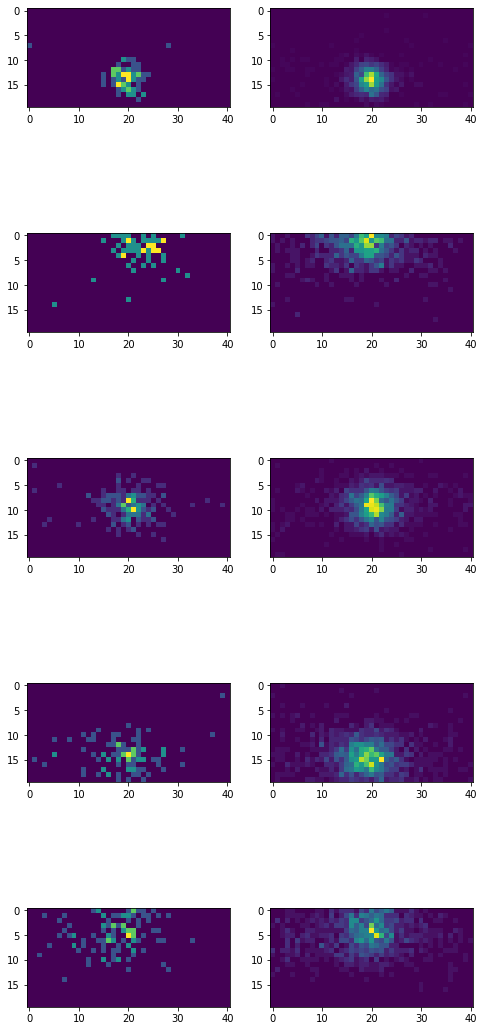

In [6]:
n = 5  # how many digits we will display

fig = plt.figure(figsize=(8,20))

for i in range(n):
    # display original
    ideas=np.random.randint(1,muestras)
    ax = fig.add_subplot(n, 2, (i)*2+1)
    plt.imshow(sector2A[ideas], cmap='viridis')
    plt.viridis()

    # display reconstruction
    ax = fig.add_subplot(n, 2, (i)*2+2)
    plt.imshow(sector2B[ideas], cmap='viridis')
    plt.viridis()

plt.show()

# print(x_test[idea])
# print(decoded_imgs[idea])
# print(decoded_imgs_scaled[idea])


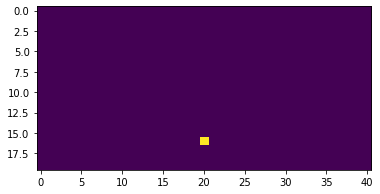

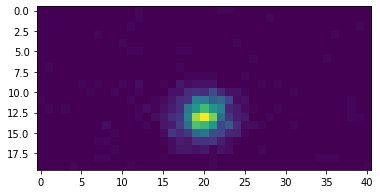

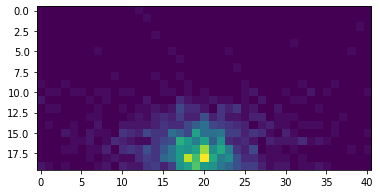

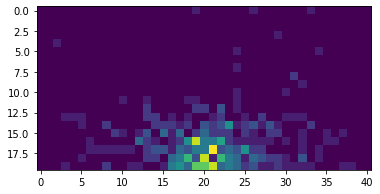

In [7]:
# convert class vectors to binary class matrices
#Y_train = np_utils.to_categorical(y_train, nb_classes)
#Y_test = np_utils.to_categorical(y_test, nb_classes)
for i in range(1,5):
    idea=np.random.randint(1,sector2B.shape[0])
    plt.imshow(sector2B[idea], cmap='viridis')
    plt.show()

In [8]:
numero_muestras=muestras
tr_size=60
val_size=20
test_size=100-val_size-tr_size
conjunto_datos_nuevo2=np.concatenate((conjunto_datos_salidas,conjunto_datos_nuevoB, conjunto_datos_nuevoA), axis=1)

tamanyo_tr=floor(tr_size*numero_muestras/100)
tamanyo_val=floor(val_size*numero_muestras/100)
tamanyo_test=numero_muestras-tamanyo_tr-tamanyo_val
print(tamanyo_tr)
print(tamanyo_val)
print(tamanyo_test)


XY_test=conjunto_datos_nuevo2[tamanyo_tr+tamanyo_val:numero_muestras,:]


XY_test_bin0=XY_test[np.where((XY_test[:,0]>=164.9999) * (XY_test[:,0]<171.000))]
XY_test_bin1=XY_test[np.where((XY_test[:,0]>=171.000) * (XY_test[:,0]<177.000))]
XY_test_bin2=XY_test[np.where((XY_test[:,0]>=177.000) * (XY_test[:,0]<183.0000))]
XY_test_bin3=XY_test[np.where((XY_test[:,0]>=183.000) * (XY_test[:,0]<189.0000))]
XY_test_bin4=XY_test[np.where((XY_test[:,0]>=189.0000))]

X_train=conjunto_datos_nuevo2[:tamanyo_tr,3:]
X_val=conjunto_datos_nuevo2[tamanyo_tr:tamanyo_tr+tamanyo_val,3:]
X_test=conjunto_datos_nuevo2[tamanyo_tr+tamanyo_val:numero_muestras,3:]

X_test_bin0=XY_test_bin0[:,3:]
Y_test_bin0=XY_test_bin0[:,0]
print(X_test_bin0.shape)
X_test_bin1=XY_test_bin1[:,3:]
Y_test_bin1=XY_test_bin1[:,0]
print(X_test_bin1.shape)
X_test_bin2=XY_test_bin2[:,3:]
Y_test_bin2=XY_test_bin2[:,0]
print(X_test_bin2.shape)
X_test_bin3=XY_test_bin3[:,3:]
Y_test_bin3=XY_test_bin3[:,0]
print(X_test_bin3.shape)
X_test_bin4=XY_test_bin4[:,3:]
Y_test_bin4=XY_test_bin4[:,0]
print(X_test_bin4.shape)



Y_train=conjunto_datos_nuevo2[:tamanyo_tr,0] #elijo la coordenada radius
Y_val=conjunto_datos_nuevo2[tamanyo_tr:tamanyo_tr+tamanyo_val,0] #elijo la corrdenada radius
Y_test=conjunto_datos_nuevo2[tamanyo_tr+tamanyo_val:numero_muestras,0] #elijo la corrdenada radius

40801
13600
13601
(5161, 1640)
(2890, 1640)
(2197, 1640)
(1718, 1640)
(1635, 1640)


In [9]:


X_train = X_train.reshape(X_train.shape[0],2, img_rows, img_cols,1)
X_val = X_val.reshape(X_val.shape[0], 2, img_rows, img_cols,1)
X_test = X_test.reshape(X_test.shape[0], 2,img_rows, img_cols,1)

X_test_bin0 = X_test_bin0.reshape(X_test_bin0.shape[0], 2, img_rows, img_cols,1)
X_test_bin1 = X_test_bin1.reshape(X_test_bin1.shape[0], 2, img_rows, img_cols,1)
X_test_bin2 = X_test_bin2.reshape(X_test_bin2.shape[0], 2, img_rows, img_cols,1)
X_test_bin3 = X_test_bin3.reshape(X_test_bin3.shape[0], 2, img_rows, img_cols,1)
X_test_bin4 = X_test_bin4.reshape(X_test_bin4.shape[0], 2, img_rows, img_cols,1)

input_shape = (2, img_rows, img_cols,1)
#input_shape=input_shape.astype('int32')

In [10]:
X_train = X_train.astype('float32')
X_val= X_val.astype('float32')
X_test = X_test.astype('float32')

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_val.shape[0], 'validation samples')
print(X_test.shape[0], 'test samples')

X_train shape: (40801, 2, 20, 41, 1)
40801 train samples
13600 validation samples
13601 test samples


Display 20 random training images using image

In [11]:
# # convert class vectors to binary class matrices
# #Y_train = np_utils.to_categorical(y_train, nb_classes)
# #Y_test = np_utils.to_categorical(y_test, nb_classes)
# for i in range(1,5):
#     idea=np.random.randint(1,X_train.shape[0])
#     plt.imshow(np.reshape(X_train[idea], [img_rows, img_cols]), cmap='viridis')
#     plt.show()

## Build the CNN. 

In [12]:
model = Sequential()

model.add(Conv3D(8, kernel_size=kernel_size,
                        padding='same',
                        data_format='channels_last',
                        input_shape=(2,img_rows,img_cols,1)))
# model.add(BatchNormalization())
model.add(Activation('tanh'))
model.add(MaxPooling3D(pool_size=pool_size))

model.add(Conv3D(16, kernel_size, padding='same'))
# model.add(BatchNormalization())
model.add(Activation('tanh'))
model.add(MaxPooling3D(pool_size=pool_size))

model.add(Conv3D(32, kernel_size, padding='same'))
# model.add(BatchNormalization())
model.add(Activation('tanh'))

model.add(Conv3D(64, kernel_size, padding='same'))
# model.add(BatchNormalization())
model.add(Activation('tanh'))

model.add(Conv3D(128, kernel_size, padding='same'))
# model.add(BatchNormalization())
model.add(Activation('tanh'))

model.add(Dropout(0.2))
model.add(Flatten())
# model.add(Dense(10))
# model.add(Activation('tanh'))
model.add(Dense(1))

dt = datetime.now().replace(second=0, microsecond=0)
experimento="CNN_kernel_{}x{}x{}_con_batchnormalization_sector_{}x{}x{}".format(kernel_size[0],kernel_size[1],kernel_size[2],img_rows,img_cols,1)
algoritmo='Nadam'
optimizador=Nadam(beta_1=0.9, beta_2=0.999)

tensorboard=TensorBoard(log_dir="../logs/defs/{}{}{}".format(experimento,algoritmo,dt))
best_model_name='../redes_CNN_R/models_best/CNN_regression_R_{}_{}_{}_{}_{}.h5'.format(nb_epoch,batch_size,experimento,algoritmo,dt)
model_check=ModelCheckpoint(best_model_name, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='min', period=1)
early_stop=EarlyStopping(monitor='val_loss', min_delta=0, patience=500, verbose=2, mode='auto', baseline=None)
model.compile(loss='mean_squared_error',
              optimizer=optimizador)



Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Show a summary of the model parameters. 

In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 2, 20, 41, 8)      264       
_________________________________________________________________
activation_1 (Activation)    (None, 2, 20, 41, 8)      0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 2, 10, 20, 8)      0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 2, 10, 20, 16)     4112      
_________________________________________________________________
activation_2 (Activation)    (None, 2, 10, 20, 16)     0         
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 2, 5, 10, 16)      0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 2, 5, 10, 32)      16416     
__________

And now train the model and evaluate on the test set. 

In [ ]:
history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch,
          verbose=1, validation_data=(X_val, Y_val),
                     callbacks=[tensorboard,model_check,early_stop])

Instructions for updating:
Use tf.cast instead.
Train on 40801 samples, validate on 13600 samples
Epoch 1/2000
40801/40801 [==============================] - 10s 237us/step - loss: 874.8143 - val_loss: 105.9901

Epoch 00001: val_loss improved from inf to 105.99015, saving model to ../redes_CNN_R/models_best/CNN_regression_R_2000_250_CNN_kernel_2x4x4_con_batchnormalization_sector_20x41x1_Nadam_2019-12-16 16:17:00.h5
Epoch 2/2000
40801/40801 [==============================] - 3s 84us/step - loss: 69.1483 - val_loss: 54.8083

Epoch 00002: val_loss improved from 105.99015 to 54.80825, saving model to ../redes_CNN_R/models_best/CNN_regression_R_2000_250_CNN_kernel_2x4x4_con_batchnormalization_sector_20x41x1_Nadam_2019-12-16 16:17:00.h5
Epoch 3/2000
40801/40801 [==============================] - 3s 84us/step - loss: 65.5044 - val_loss: 38.3456

Epoch 00003: val_loss improved from 54.80825 to 38.34556, saving model to ../redes_CNN_R/models_best/CNN_regression_R_2000_250_CNN_kernel_2x4x4_con_b

In [ ]:
dt = datetime.now().replace(second=0, microsecond=0)
model.save_weights('../redes_CNN_R/defs/CNN_regression_R_{}_{}_{}_{}_{}'.format(nb_epoch,batch_size,experimento,algoritmo,dt))

In [ ]:
best_model = load_model(best_model_name)
score = best_model.evaluate(X_test, Y_test, verbose=0)
print('Test mse:', score)
# print('Test mae:', score[1])
Y_test_predicted=model.predict(X_test)
print(Y_test_predicted[:10].flatten())
print(Y_test[:10])
error_prediction=Y_test-Y_test_predicted.flatten()

print(error_prediction[:10])

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model error')
plt.ylabel('error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
#print(error_prediction)

In [ ]:

n, bins, patches = plt.hist(error_prediction, 400, normed=0, facecolor='green', alpha=0.75)
plt.title("Histogram with 400 bins")
plt.show()
x=bins[:400]
y=n
print(n.shape)
print(bins.shape)
from numpy import exp, loadtxt, pi, sqrt, log

from lmfit import Model
def gaussian(x, amp, cen, wid):
    """1-d gaussian: gaussian(x, amp, cen, wid)"""
    return amp * exp(-((x-cen)/wid)**2 )


gmodel = Model(gaussian)
result = gmodel.fit(y, x=x, amp=1000, cen=0, wid=1)

print(result.fit_report())

plt.plot(x, y, 'bo')
plt.plot(x, result.init_fit, 'k--')
plt.plot(x, result.best_fit, 'r-')
plt.show()





In [ ]:
FWHM=result.params['wid'].value*2*sqrt(log(2))

In [ ]:
print(FWHM)

In [ ]:
Y_test_bin0_predicted=model.predict(X_test_bin0)
print(Y_test_bin0_predicted)
error_prediction_bin0=Y_test_bin0-Y_test_bin0_predicted.flatten()
n, bins, patches = plt.hist(error_prediction_bin0, 400, normed=0, facecolor='green', alpha=0.75)

x=bins[:400]
y=n

gmodel = Model(gaussian)
result = gmodel.fit(y, x=x, amp=1000, cen=0, wid=1)
FWHM_bin0=result.params['wid'].value*2*sqrt(log(2))
print(FWHM_bin0)

In [ ]:
Y_test_bin1_predicted=model.predict(X_test_bin1)
#print(Y_test_bin1_predicted)
error_prediction_bin1=Y_test_bin1-Y_test_bin1_predicted.flatten()
n, bins, patches = plt.hist(error_prediction_bin1, 400, normed=0, facecolor='green', alpha=0.75)

x=bins[:400]
y=n

gmodel = Model(gaussian)
result = gmodel.fit(y, x=x, amp=1000, cen=0, wid=1)
FWHM_bin1=result.params['wid'].value*2*sqrt(log(2))
print(FWHM_bin1)

In [ ]:
Y_test_bin2_predicted=model.predict(X_test_bin2)
#print(Y_test_bin2_predicted)
error_prediction_bin2=Y_test_bin2-Y_test_bin2_predicted.flatten()
n, bins, patches = plt.hist(error_prediction_bin2, 400, normed=0, facecolor='green', alpha=0.75)

x=bins[:400]
y=n

gmodel = Model(gaussian)
result = gmodel.fit(y, x=x, amp=1000, cen=0, wid=1)
FWHM_bin2=result.params['wid'].value*2*sqrt(log(2))
print(FWHM_bin2)

In [ ]:
Y_test_bin3_predicted=model.predict(X_test_bin3)
#print(Y_test_bin3_predicted)
error_prediction_bin3=Y_test_bin3-Y_test_bin3_predicted.flatten()
n, bins, patches = plt.hist(error_prediction_bin3, 400, normed=0, facecolor='green', alpha=0.75)

x=bins[:400]
y=n

gmodel = Model(gaussian)
result = gmodel.fit(y, x=x, amp=1000, cen=0, wid=1)
FWHM_bin3=result.params['wid'].value*2*sqrt(log(2))
print(FWHM_bin3)

In [ ]:
Y_test_bin4_predicted=model.predict(X_test_bin4)
#print(Y_test_bin4_predicted)
error_prediction_bin4=Y_test_bin4-Y_test_bin4_predicted.flatten()
n, bins, patches = plt.hist(error_prediction_bin4, 400, normed=0, facecolor='green', alpha=0.75)

x=bins[:400]
y=n

gmodel = Model(gaussian)
result = gmodel.fit(y, x=x, amp=1000, cen=0, wid=1)
FWHM_bin4=result.params['wid'].value*2*sqrt(log(2))
print(FWHM_bin4)
print(FWHM_bin3)
print(FWHM_bin2)
print(FWHM_bin1)
print(FWHM_bin0)

Veamos ahora los histogramnas 2d que nos interesan